In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error
import folium
import openrouteservice as ors
from openrouteservice import convert
import time
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Read in the data
# Read in the data in chunks in for loop and then convert it to a dataframe and see the time it takes to read the data
start_time = time.time()
cap_bks_oct = pd.DataFrame()

for chunk in pd.read_csv('202310-capitalbikeshare-tripdata.csv', chunksize=200000, low_memory=False):
    print('Number of chunks read: ', chunk.shape)
    cap_bks_oct  = pd.concat([cap_bks_oct , chunk])

print("Time taken to read the data: ", time.time() - start_time)

print("Shape of the dataframe: ", cap_bks_oct .shape)

# Check for missing values
print("Missing Values:")
print(cap_bks_oct.isnull().sum()/cap_bks_oct.shape[0])

# Drop the missing values
cap_bks_oct.dropna(inplace=True)

# Check for duplicates
print("Duplicates: ", cap_bks_oct.duplicated().sum())

# Downsample the data
cap_bks_oct = cap_bks_oct[: : 4]

Number of chunks read:  (200000, 13)
Number of chunks read:  (200000, 13)
Number of chunks read:  (91084, 13)
Time taken to read the data:  1.0726540088653564
Shape of the dataframe:  (491084, 13)
Missing Values:
ride_id               0.000000
rideable_type         0.000000
started_at            0.000000
ended_at              0.000000
start_station_name    0.115274
start_station_id      0.115274
end_station_name      0.122297
end_station_id        0.122297
start_lat             0.000000
start_lng             0.000000
end_lat               0.001112
end_lng               0.001112
member_casual         0.000000
dtype: float64
Duplicates:  0


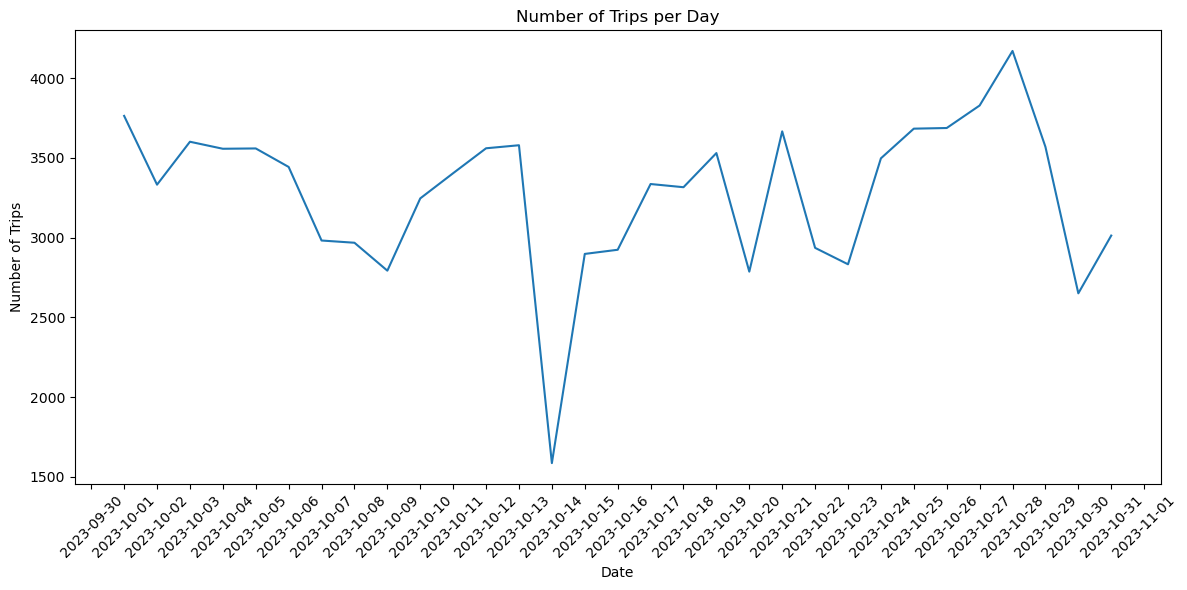

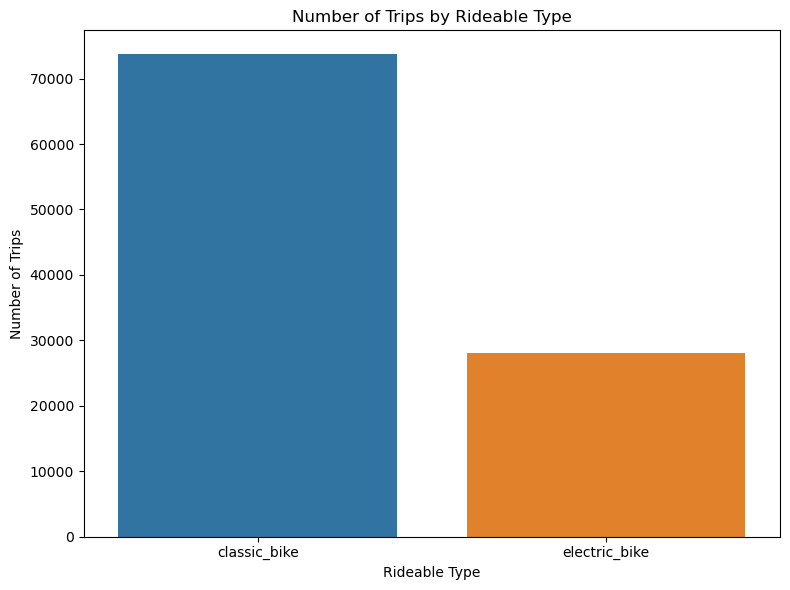

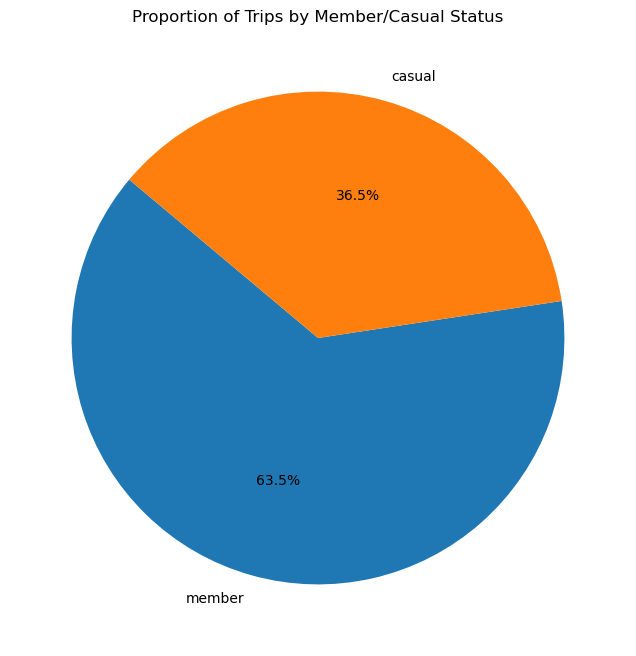

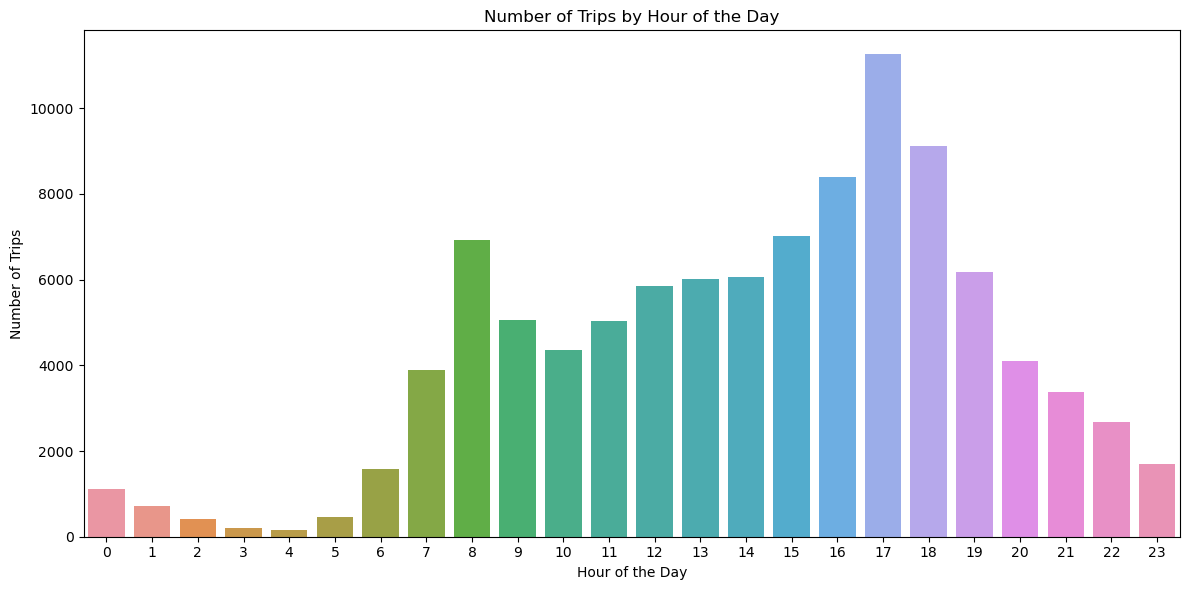

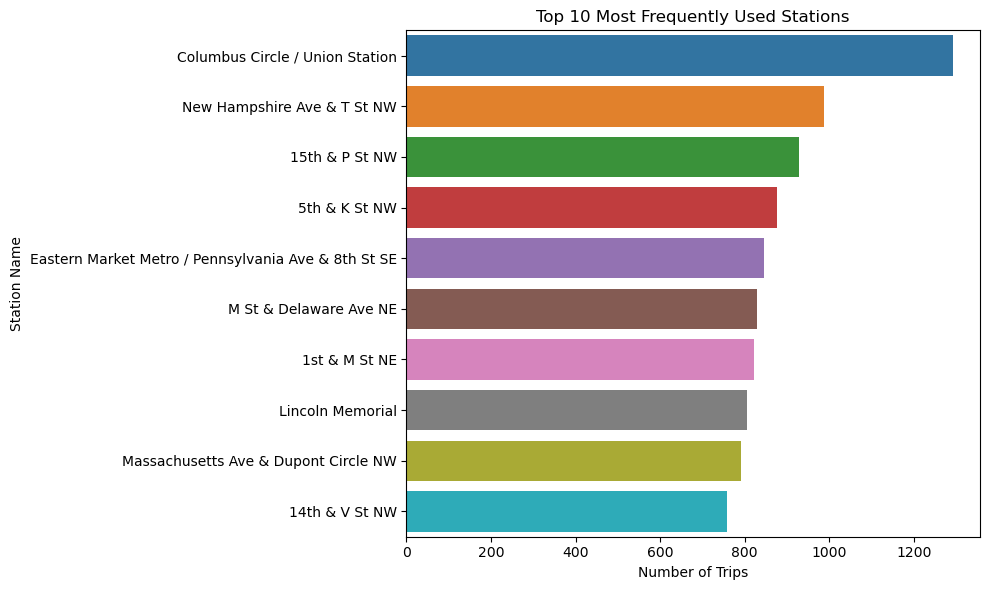

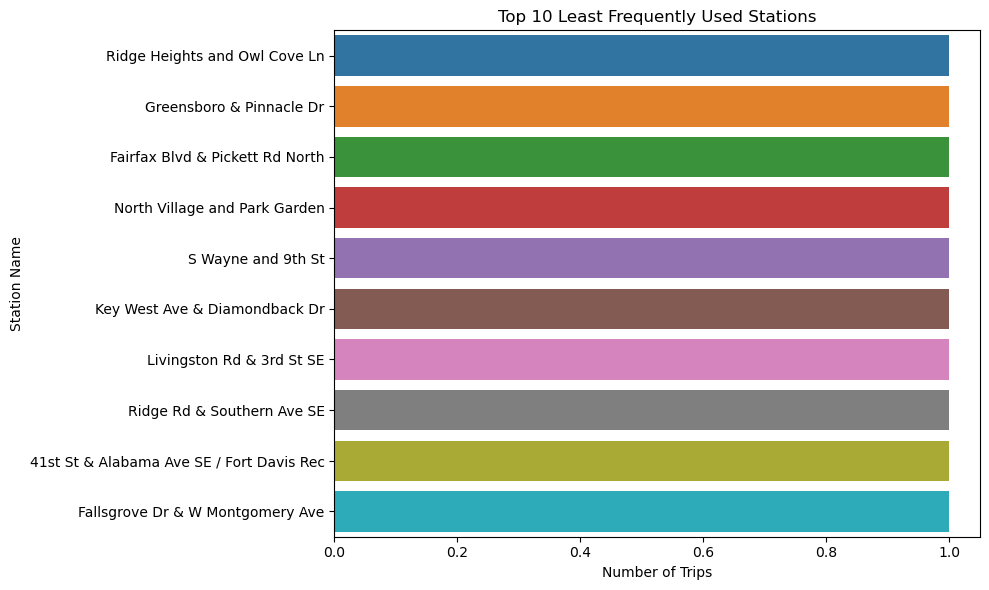

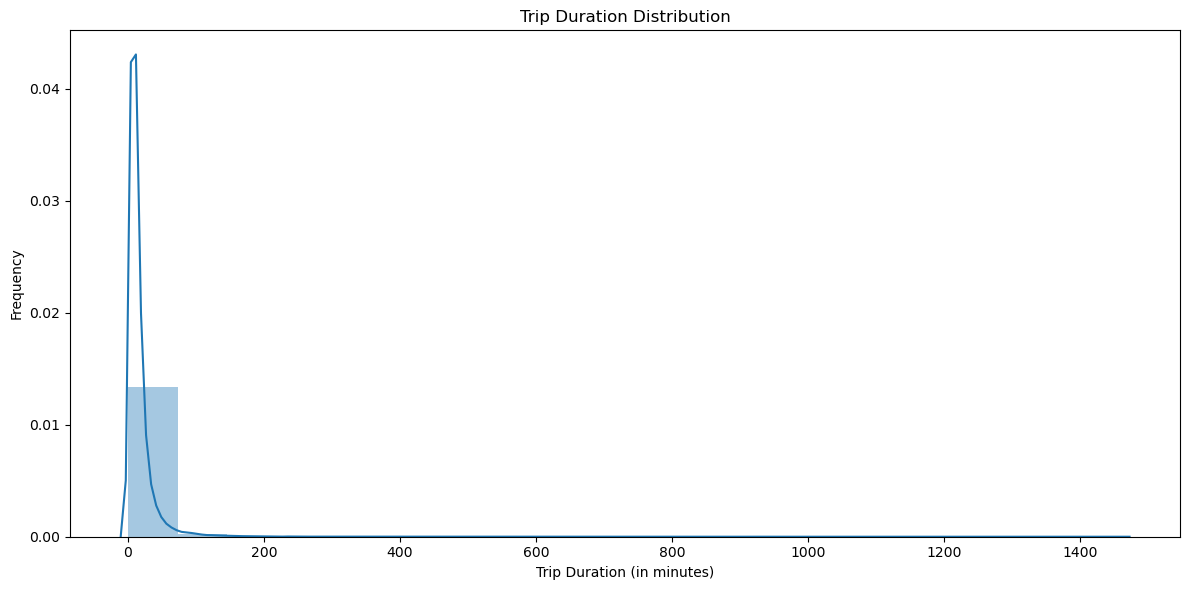

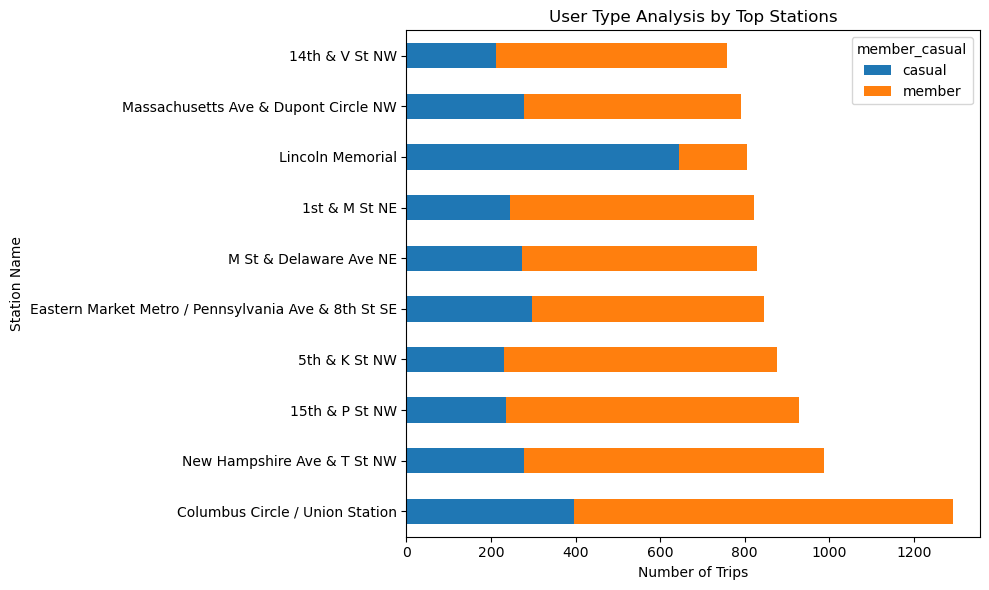

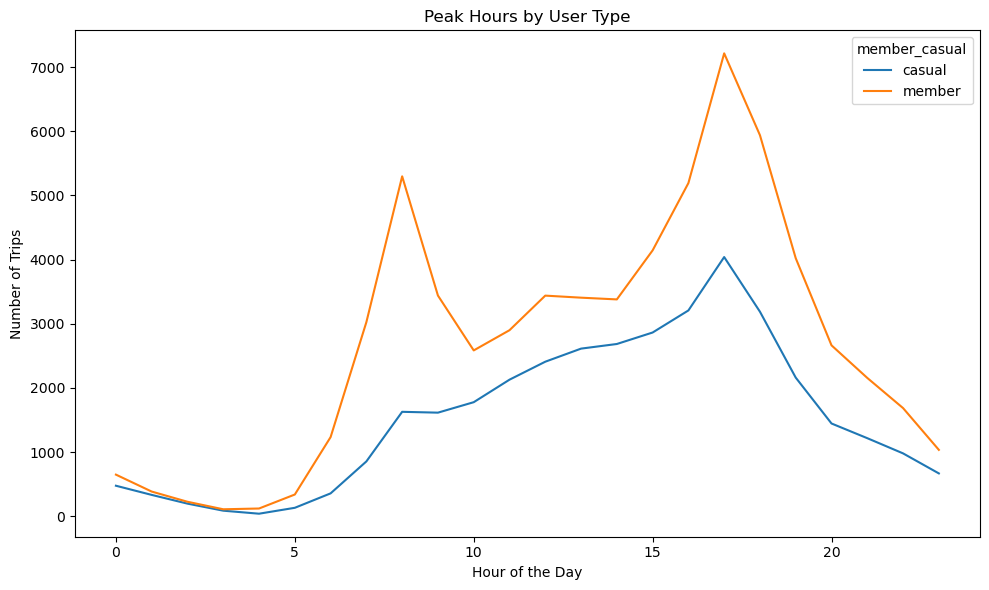

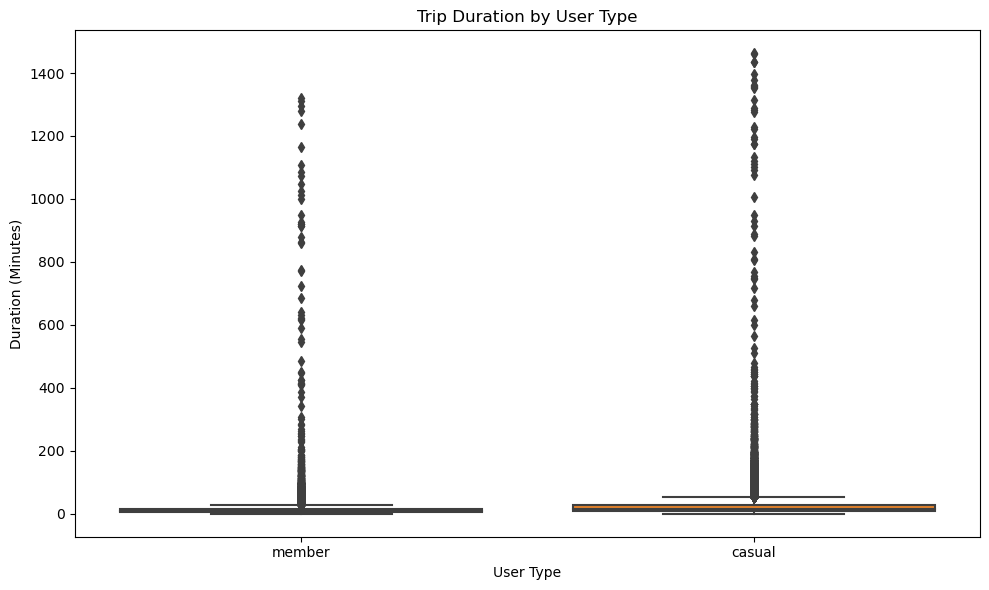

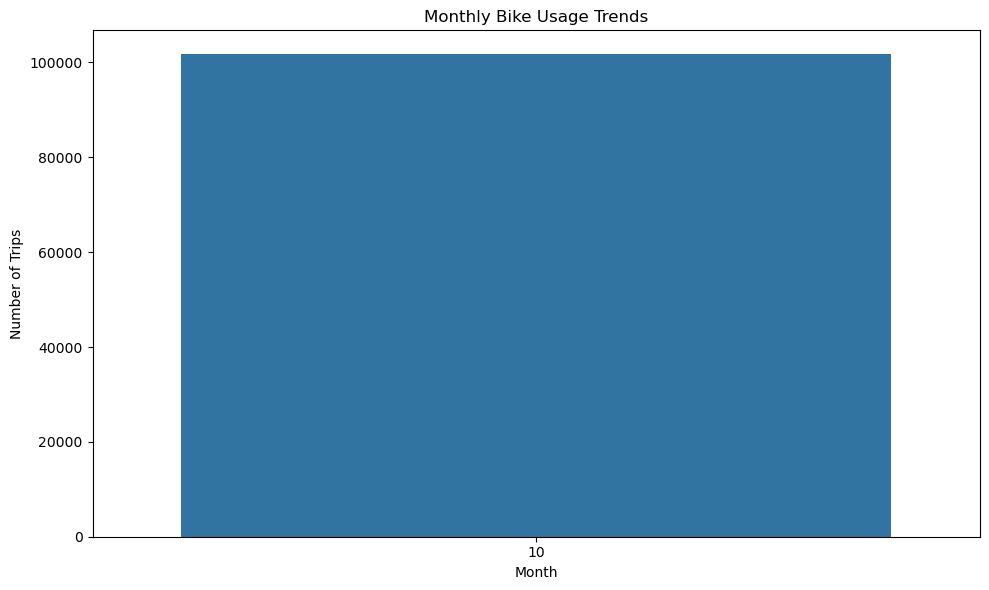

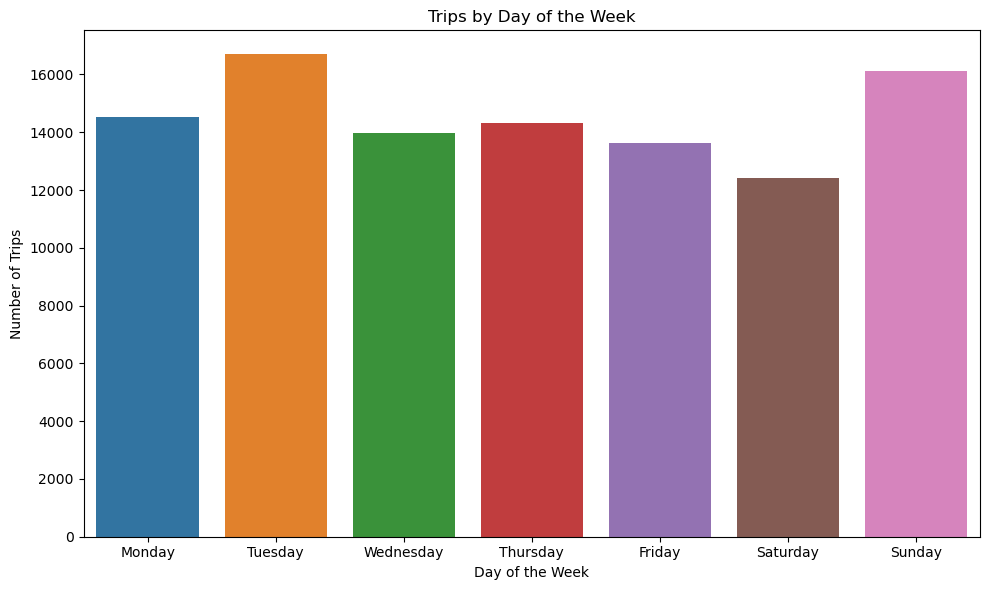

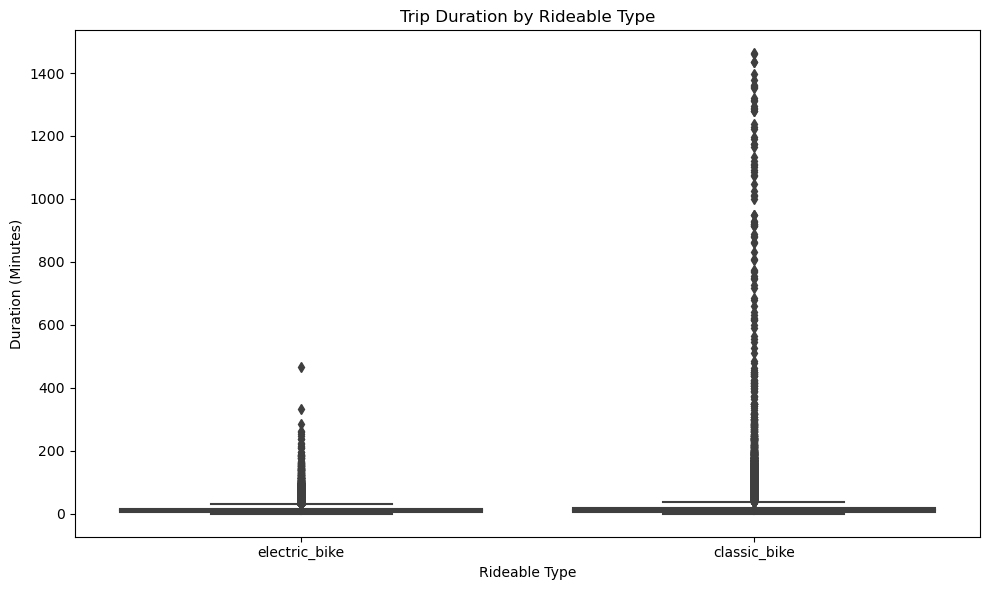

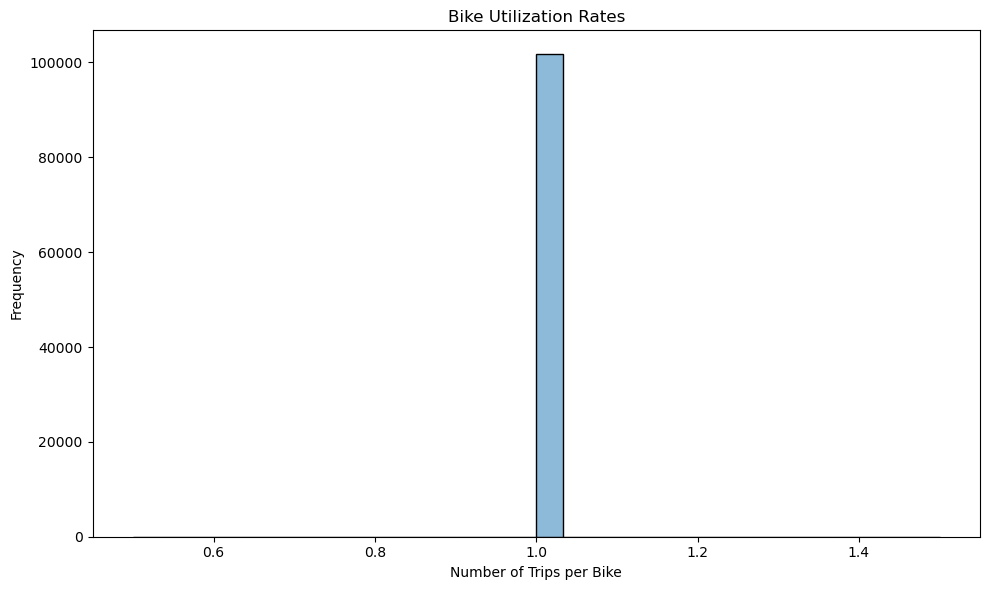

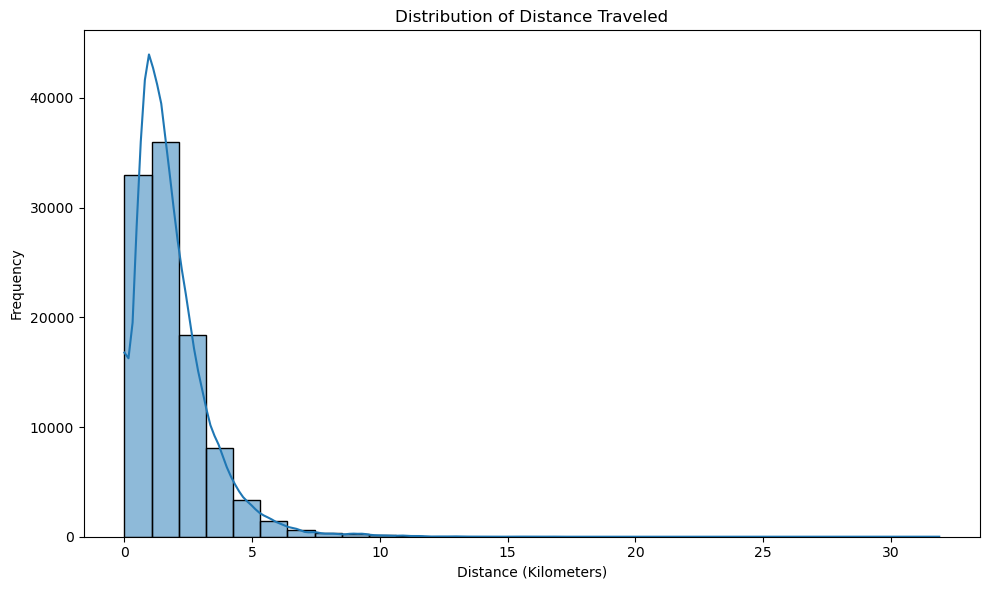

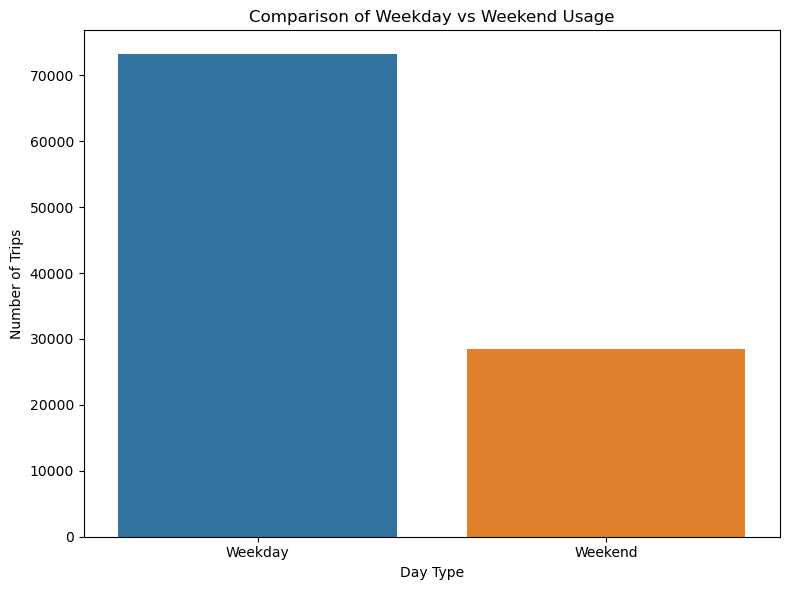

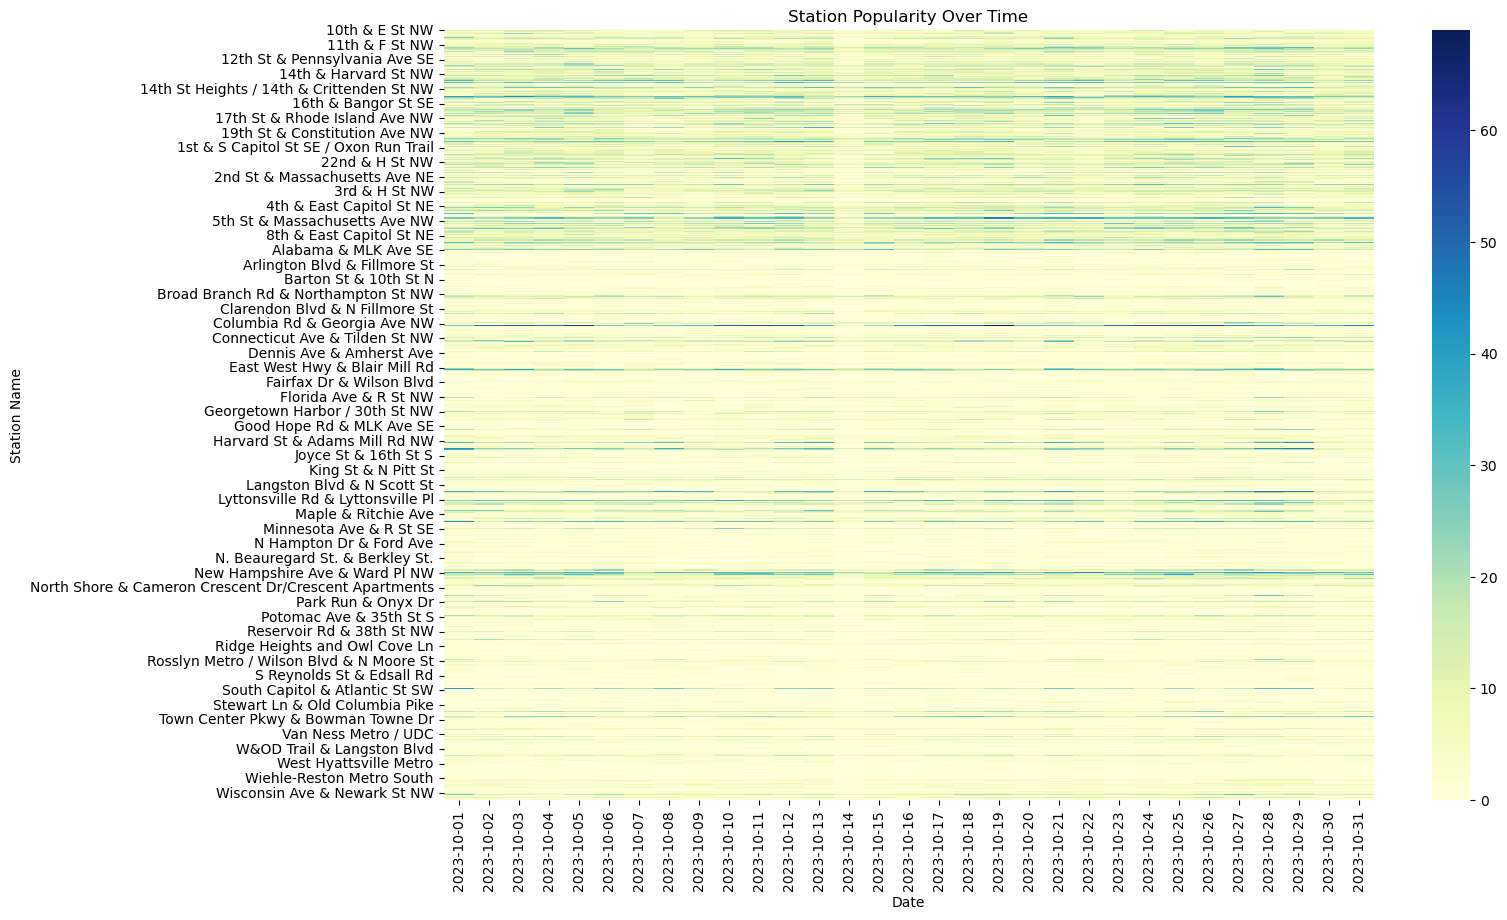

In [3]:
# EDA of capital bikesahre data

# Line plots for number of trips per day
cap_bks_oct['started_at'] = pd.to_datetime(cap_bks_oct['started_at'])
cap_bks_oct['ended_at'] = pd.to_datetime(cap_bks_oct['ended_at'])
cap_bks_oct['start_date'] = cap_bks_oct['started_at'].dt.date
trips_per_day = cap_bks_oct['start_date'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=trips_per_day.index, y=trips_per_day.values)
plt.title('Number of Trips per Day')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
plt.show()

# Bar chart for number of trips by rideable type
trips_by_rideable_type = cap_bks_oct['rideable_type'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=trips_by_rideable_type.index, y=trips_by_rideable_type.values)
plt.title('Number of Trips by Rideable Type')
plt.xlabel('Rideable Type')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

# Count plot of trips based member status
trips_by_member_casual = cap_bks_oct['member_casual'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(trips_by_member_casual, labels=trips_by_member_casual.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Trips by Member/Casual Status')
plt.show()

# Count plot of number of trips by hour of the day
cap_bks_oct['start_hour'] = cap_bks_oct['started_at'].dt.hour
trips_by_hour = cap_bks_oct['start_hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=trips_by_hour.index, y=trips_by_hour.values)
plt.title('Number of Trips by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

# Bar plot of most frequent used stations
most_used_stations = cap_bks_oct['start_station_name'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=most_used_stations.index, x=most_used_stations.values, orient='h')
plt.title('Top 10 Most Frequently Used Stations')
plt.xlabel('Number of Trips')
plt.ylabel('Station Name')
plt.tight_layout()
plt.show()

# Bar plot of most least used stations
least_used_stations = cap_bks_oct['start_station_name'].value_counts().nsmallest(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=least_used_stations.index, x=least_used_stations.values, orient='h')
plt.title('Top 10 Least Frequently Used Stations')
plt.xlabel('Number of Trips')
plt.ylabel('Station Name')
plt.tight_layout()
plt.show()

# Histogram of trip duration
cap_bks_oct['trip_duration'] = (cap_bks_oct['ended_at'] - cap_bks_oct['started_at']).dt.total_seconds() / 60

plt.figure(figsize=(12, 6))
sns.distplot(cap_bks_oct['trip_duration'], kde=True, bins=20)
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration (in minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Stacked bar plot of trips by station and user type
user_type_by_station = cap_bks_oct.groupby(['start_station_name', 'member_casual']).size().unstack().fillna(0)
top_stations = user_type_by_station.sum(axis=1).nlargest(10).index
top_stations_data = user_type_by_station.loc[top_stations]

top_stations_data.plot(kind='barh', stacked=True, figsize=(10, 6))
plt.title('User Type Analysis by Top Stations')
plt.xlabel('Number of Trips')
plt.ylabel('Station Name')
plt.tight_layout()
plt.show()

# Line plot of peak hours by user type
peak_hours_by_user_type = cap_bks_oct.groupby(['start_hour', 'member_casual']).size().unstack().fillna(0)

peak_hours_by_user_type.plot(kind='line', figsize=(10, 6))
plt.title('Peak Hours by User Type')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

# Box plot for trip durations by user type
plt.figure(figsize=(10, 6))
sns.boxplot(data=cap_bks_oct, x='member_casual', y='trip_duration')
plt.title('Trip Duration by User Type')
plt.xlabel('User Type')
plt.ylabel('Duration (Minutes)')
plt.tight_layout()
plt.show()

# Bar plot of monthly trips
cap_bks_oct['start_month'] = cap_bks_oct['started_at'].dt.month
monthly_trips = cap_bks_oct.groupby('start_month').size()

plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_trips.index, y=monthly_trips.values)
plt.title('Monthly Bike Usage Trends')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

# Bar chart for trips by day of the week
cap_bks_oct['day_of_week'] = cap_bks_oct['started_at'].dt.day_name()
trips_by_day_of_week = cap_bks_oct['day_of_week'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=trips_by_day_of_week.index, y=trips_by_day_of_week.values, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Trips by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

# Box plot for trip durations by rideable type
plt.figure(figsize=(10, 6))
sns.boxplot(data=cap_bks_oct, x='rideable_type', y='trip_duration')
plt.title('Trip Duration by Rideable Type')
plt.xlabel('Rideable Type')
plt.ylabel('Duration (Minutes)')
plt.tight_layout()
plt.show()

# Histogram for ride utilization
bike_utilization = cap_bks_oct['ride_id'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(bike_utilization, bins=30, kde=True)
plt.title('Bike Utilization Rates')
plt.xlabel('Number of Trips per Bike')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Histogram for the distance traveled
def calculate_distance(row):
    start_point = (row['start_lat'], row['start_lng'])
    end_point = (row['end_lat'], row['end_lng'])
    return geodesic(start_point, end_point).kilometers

cap_bks_oct['distance'] = cap_bks_oct.apply(calculate_distance, axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(cap_bks_oct['distance'], bins=30, kde=True)
plt.title('Distribution of Distance Traveled')
plt.xlabel('Distance (Kilometers)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Bar chart for weekday vs weekend usage
cap_bks_oct['day_type'] = cap_bks_oct['day_of_week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Count trips by day type
trips_by_day_type = cap_bks_oct['day_type'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=trips_by_day_type.index, y=trips_by_day_type.values)
plt.title('Comparison of Weekday vs Weekend Usage')
plt.xlabel('Day Type')
plt.ylabel('Number of Trips')
plt.tight_layout()
plt.show()

# Heatmap of station popularity over time
station_popularity = cap_bks_oct.groupby(['start_station_name', cap_bks_oct['started_at'].dt.date]).size().unstack(fill_value=0)

plt.figure(figsize=(15, 10))
sns.heatmap(station_popularity, cmap="YlGnBu")
plt.title('Station Popularity Over Time')
plt.xlabel('Date')
plt.ylabel('Station Name')
plt.show()

In [3]:
# Geospatial analysis of bikeshare data

In [4]:
# Load metro data of Washington DC
metro_data = pd.read_csv('Metro_Stations_Regional_Updated.csv')
metro_data.head()

,X,Y,NAME,ADDRESS,LINE
0,-76.911466,38.826454,Branch Ave,"4704 OLD SOPER ROAD, SUITLAND, MD",green
1,-77.053670,38.814151,Braddock Road,"700 N. WEST ST., ALEXANDRIA, VA","blue, yellow"
2,-77.060813,38.806594,King St-Old Town,"1900 KING STREET, ALEXANDRIA, VA","blue, yellow"
3,-77.070877,38.800433,Eisenhower Ave,"2400 EISENHOWER AVENUE, ALEXANDRIA, VA",yellow
4,-77.075208,38.793924,Huntington,"2701 HUNTINGTON AVENUE, ALEXANDRIA, VA",yellow


In [5]:
# EDA of metro data

In [6]:
# Geospatial analysis of metro data

In [5]:
#------------------------------------------------------------------------------------------
# Main Task No. 1: Combined analysis by integrating capital bike share data with metro data
#------------------------------------------------------------------------------------------

# 1. Nearest Metro Station Analysis
print(metro_data.columns)

def find_nearest_metro(bike_coords, metro_coords, metro_df):
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(metro_coords)
    distances, indices = neigh.kneighbors(bike_coords)

    nearest_metro_stations = metro_df.iloc[indices.flatten()]["NAME"]
    return nearest_metro_stations.values, distances.flatten()

bike_start_coords = cap_bks_oct[['start_lat', 'start_lng']].values
bike_end_coords = cap_bks_oct[['end_lat', 'end_lng']].values
metro_coords = metro_data[['Y', 'X']].values

nearest_metro_start, start_distances = find_nearest_metro(bike_start_coords, metro_coords, metro_data)
nearest_metro_end, end_distances = find_nearest_metro(bike_end_coords, metro_coords, metro_data)

cap_bks_oct['nearest_start_metro'] = nearest_metro_start
cap_bks_oct['start_metro_distance'] = start_distances
cap_bks_oct['nearest_end_metro'] = nearest_metro_end
cap_bks_oct['end_metro_distance'] = end_distances

cap_bks_oct['start_metro_distance'] = cap_bks_oct['start_metro_distance'].round(2)
cap_bks_oct['end_metro_distance'] = cap_bks_oct['end_metro_distance'].round(2)

# Now you can display the head of the DataFrame to check the results
print(cap_bks_oct.head())

# 2. Bike Usage Patterns in Relation to Nearby Metro Stations
near_metro_threshold = 0.5
cap_bks_oct['start_near_metro'] = cap_bks_oct['start_metro_distance'] <= near_metro_threshold
cap_bks_oct['end_near_metro'] = cap_bks_oct['end_metro_distance'] <= near_metro_threshold

# Counting trips starting or ending near a metro
start_near_metro_count = cap_bks_oct['start_near_metro'].sum()
end_near_metro_count = cap_bks_oct['end_near_metro'].sum()

cap_bks_oct['ended_at'] = pd.to_datetime(cap_bks_oct['ended_at'])
cap_bks_oct['started_at'] = pd.to_datetime(cap_bks_oct['started_at'])

cap_bks_oct['trip_duration'] = (cap_bks_oct['ended_at'] - cap_bks_oct['started_at']).dt.total_seconds() / 60

# 3. Relationship Between Trip Duration and Proximity to Metro Stations
avg_duration_near_metro_start = cap_bks_oct[cap_bks_oct['start_near_metro']]['trip_duration'].mean()
avg_duration_far_metro_start = cap_bks_oct[~cap_bks_oct['start_near_metro']]['trip_duration'].mean()
avg_duration_near_metro_end = cap_bks_oct[cap_bks_oct['end_near_metro']]['trip_duration'].mean()
avg_duration_far_metro_end = cap_bks_oct[~cap_bks_oct['end_near_metro']]['trip_duration'].mean()

# 4. Bike usage patterns on different metro lines
metro_lines = metro_data.set_index('NAME')['LINE'].to_dict()
cap_bks_oct['start_metro_line'] = cap_bks_oct['nearest_start_metro'].map(metro_lines)
cap_bks_oct['end_metro_line'] = cap_bks_oct['nearest_end_metro'].map(metro_lines)

# 5. Most popular metro stations for bike users
start_station_popularity = cap_bks_oct[cap_bks_oct['start_near_metro']]['nearest_start_metro'].value_counts()
end_station_popularity = cap_bks_oct[cap_bks_oct['end_near_metro']]['nearest_end_metro'].value_counts()
combined_station_popularity = start_station_popularity.add(end_station_popularity, fill_value=0)
most_popular_stations = combined_station_popularity.sort_values(ascending=False)
print("Most Popular Metro Stations for Bike Users:")
print(most_popular_stations.head(10))

Index(['X', 'Y', 'NAME', 'ADDRESS', 'LINE'], dtype='object')
             ride_id  rideable_type          started_at            ended_at  \
0   CB181909FC05004F  electric_bike 2023-10-29 09:10:14 2023-10-29 09:25:19   
4   C3CD670D215D5202   classic_bike 2023-10-23 18:30:45 2023-10-23 18:43:23   
8   DE5E49E0F8EF832A   classic_bike 2023-10-01 19:55:17 2023-10-01 20:04:07   
12  28394A68430BA6FA  electric_bike 2023-10-27 06:24:10 2023-10-27 06:32:23   
16  B80203E5C63A0317   classic_bike 2023-10-22 09:53:25 2023-10-22 09:56:55   

                              start_station_name  start_station_id  \
0                           11th & Clifton St NW           31136.0   
4   W&OD Trail/Sunset Hills Rd & Isaac Newton Sq           32220.0   
8             36th & Calvert St NW / Glover Park           31304.0   
12                    The Mall at Prince Georges           32422.0   
16                          11th & Clifton St NW           31136.0   

                                     end_st

In [6]:
#------------------------------------------------------------------------------------------
# Main Task No. 2: User-behavioral analysis of capital bike share users
#------------------------------------------------------------------------------------------

# Check if datatime object already
cap_bks_oct['started_at'] = pd.to_datetime(cap_bks_oct['started_at'], errors='coerce')
cap_bks_oct['ended_at'] = pd.to_datetime(cap_bks_oct['ended_at'], errors='coerce')

print(cap_bks_oct['started_at'].dtype)

if pd.api.types.is_datetime64_any_dtype(cap_bks_oct['started_at']):
    cap_bks_oct['start_hour'] = cap_bks_oct['started_at'].dt.hour
    cap_bks_oct['end_hour'] = cap_bks_oct['ended_at'].dt.hour
    cap_bks_oct['day_of_week'] = cap_bks_oct['started_at'].dt.dayofweek
    cap_bks_oct['month'] = cap_bks_oct['started_at'].dt.month
else:
    print("Error: 'started_at' is not in a datetime format.")

cap_bks_oct['start_hour'] = cap_bks_oct['started_at'].dt.hour
cap_bks_oct['end_hour'] = cap_bks_oct['ended_at'].dt.hour
cap_bks_oct['day_of_week'] = cap_bks_oct['started_at'].dt.dayofweek
cap_bks_oct['month'] = cap_bks_oct['started_at'].dt.month

cap_bks_oct['user_type'] = cap_bks_oct['member_casual'].map({'casual': 0, 'member': 1})

def calculate_distance(row):
    start_point = (row['start_lat'], row['start_lng'])
    end_point = (row['end_lat'], row['end_lng'])
    return geodesic(start_point, end_point).kilometers

cap_bks_oct['distance'] = cap_bks_oct.apply(calculate_distance, axis=1)

new_cap_bks_oct = cap_bks_oct[['distance', 'trip_duration', 'start_hour', 'end_hour', 'start_lat', 'start_lng',
                                 'end_lat', 'end_lng', 'start_metro_distance',
                                    'end_metro_distance', 'day_of_week', 'month', 'user_type']]

new_cap_bks_oct = pd.get_dummies(new_cap_bks_oct, columns=['day_of_week', 'month'], drop_first=True)

numerical_features = ['trip_duration', 'start_hour', 'end_hour', 'start_lat', 'start_lng',
                      'end_lat', 'end_lng', 'start_metro_distance',
                      'end_metro_distance']

def scale_features(df, features):
    for feature in features:
        df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()

    return df

new_cap_bks_oct = scale_features(new_cap_bks_oct, numerical_features)

# Clustering
kmeans = KMeans(n_clusters=2, random_state=5834)

cluster = kmeans.fit_predict(new_cap_bks_oct)

new_cap_bks_oct['cluster'] = cluster

silhouette_avg = silhouette_score(new_cap_bks_oct, cluster)
print("Silhouette Score: ", silhouette_avg)

def user_type_cluster(df):
    user_type = df.groupby('cluster').agg({
        'trip_duration': 'mean',
        'distance': 'mean',
        'start_metro_distance': 'mean',
        'end_metro_distance': 'mean',
    })

    return user_type

print(user_type_cluster(new_cap_bks_oct))

# Means are centered around zero. Values close to zero are around the average, positive values are above average, and negative values are below average.
# Cluster 0: Casual Users: Shorter trips, start closer to metro stations and tend to end further from metro stations
# Cluster 1: Member Users: Longer trips, start further from metro stations and tend to end closer to metro stations

datetime64[ns]
Silhouette Score:  0.17633828982609406
         trip_duration  distance  start_metro_distance  end_metro_distance
cluster                                                                   
0            -0.041893  1.612259             -0.077644            0.067547
1             0.062190  2.212056              0.115262           -0.100273


In [7]:
#------------------------------------------------------------------------------------------
# Main Task No. 3: Predicting trip duration of a bike rider
#------------------------------------------------------------------------------------------

# Create new features
cap_bks_oct['num_bikes_available_start'] = 0
cap_bks_oct['num_free_docks_end'] = 0

cap_bks_oct.sort_values('started_at', inplace=True)

cap_bks_oct['bikes_out_cumsum'] = cap_bks_oct.groupby('start_station_id').cumcount()

cap_bks_oct.sort_values('ended_at', inplace=True)

cap_bks_oct['bikes_in_cumsum'] = cap_bks_oct.groupby('end_station_id').cumcount()

cap_bks_oct['shifted_bikes_in_cumsum'] = cap_bks_oct.groupby('end_station_id')['bikes_in_cumsum'].shift(1).fillna(0)

cap_bks_oct.sort_values(by=['start_station_id', 'started_at'], inplace=True)

cap_bks_oct['num_bikes_available_start'] = cap_bks_oct['shifted_bikes_in_cumsum'] - cap_bks_oct['bikes_out_cumsum']

cap_bks_oct.sort_values(by=['end_station_id', 'ended_at'], inplace=True)

cap_bks_oct['shifted_bikes_out_cumsum'] = cap_bks_oct.groupby('start_station_id')['bikes_out_cumsum'].shift(-1).fillna(method='ffill')

cap_bks_oct['num_free_docks_end'] = cap_bks_oct['shifted_bikes_out_cumsum'] - cap_bks_oct['bikes_in_cumsum']

cap_bks_oct['num_bikes_available_start'] = cap_bks_oct['num_bikes_available_start'].clip(lower=0)

cap_bks_oct['num_free_docks_end'] = cap_bks_oct['num_free_docks_end'].clip(lower=0)

features = [
    'start_hour', 'day_of_week', 'month',
    'start_station_id', 'end_station_id',
    'start_metro_distance', 'end_metro_distance',
    'num_free_docks_end', 'num_bikes_available_start',
    'user_type'
]

X = cap_bks_oct[features]
y = cap_bks_oct['trip_duration']

X.drop(['start_station_id', 'end_station_id'], axis=1, inplace=True)

X = pd.get_dummies(X, columns=['day_of_week', 'month'], drop_first=True)

numerical_features = ['start_hour', 'start_metro_distance', 'end_metro_distance', 'num_free_docks_end', 'num_bikes_available_start']

X = scale_features(X, numerical_features)

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=5834)

rf = RandomForestRegressor(n_estimators=100, random_state=5834)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE:{mae:.2f}")
print(f"MSE:{mse:.2f}")
print(f"RMSE:{rmse:.2f}")


MAE:13.30
MSE:1509.59
RMSE:38.85


In [8]:
#------------------------------------------------------------------------------------------
# Main Task No. 4: Route optimization for capital bike share and metro data
#------------------------------------------------------------------------------------------

# Subtask 1: Find nearest metro stations to the start and end coordinates of the bike stations given by the user.
# Task: A person is wants to travel from point A to point B with a capital bike share to the metro staiton.
# The person wants to know the best route to take to reach the nearest bike station.
# After reaching the nearest bike station, the person wants to know the best route to take to reach the nearest metro station 
# by walking.
# All the routes should be plotted on one map.

client = ors.Client(key='5b3ce3597851110001cf6248fffd11b1621b4945a809731a7440c503')

start_lat = float(input("Enter the latitude of the starting point: "))
start_lng = float(input("Enter the longitude of the starting point: "))

end_lat = float(input("Enter the latitude of the ending point: "))
end_lng = float(input("Enter the longitude of the ending point: "))

def get_nearest_bike_stations(lat, lng, num_stations=1):
    stations = cap_bks_oct[['start_station_id', 'start_station_name', 'start_lat', 'start_lng']].drop_duplicates()
    stations['distance'] = stations.apply(lambda row: geodesic((lat, lng), (row['start_lat'], row['start_lng'])).kilometers, axis=1)
    stations.sort_values('distance', inplace=True)
    return stations.head(num_stations)

start_stations = get_nearest_bike_stations(start_lat, start_lng)

end_stations = get_nearest_bike_stations(end_lat, end_lng)

print("Nearest Bike Stations to Start Coordinates:")
print(start_stations)

print("Nearest Bike Stations to End Coordinates:")
print(end_stations)


Enter the latitude of the starting point: 38.90046849
Enter the longitude of the starting point: -76.94728732
Enter the latitude of the ending point: 38.888524
Enter the longitude of the ending point: -76.913188
Nearest Bike Stations to Start Coordinates:
       start_station_id              start_station_name  start_lat  start_lng  \
27177           31717.0  Kenilworth Terr & Hayes St. NE  38.900468 -76.947287   

           distance  
27177  2.584422e-07  
Nearest Bike Stations to End Coordinates:
        start_station_id     start_station_name  start_lat  start_lng  \
314066           32419.0  Capitol Heights Metro  38.888524 -76.913188   

        distance  
314066       0.0  


In [9]:
def get_nearest_metro_station(lat, lng):
    metro_coords = metro_data[['Y', 'X']].values
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(metro_coords)
    distances, indices = neigh.kneighbors([(lat, lng)])
    nearest_metro_station = metro_data.iloc[indices.flatten()]
    return nearest_metro_station

nearest_metro_station = get_nearest_metro_station(end_lat, end_lng)

print("Nearest Metro Station to End Coordinates:")
print(nearest_metro_station)

Nearest Metro Station to End Coordinates:
           X          Y             NAME  \
37 -76.91181  38.889474  Capitol Heights   

                                    ADDRESS                  LINE  
37  133 CENTRAL AVENUE, CAPITOL HEIGHTS, MD  blue, orange, silver  


In [10]:
# Get the route from the start to end coordinates of bike station
def get_route(start_lat, start_lng, end_lat, end_lng):
    coords = ((start_lng, start_lat), (end_lng, end_lat))
    response = client.directions(coords)
    encoded_route = response['routes'][0]['geometry']
    decoded_route = convert.decode_polyline(encoded_route)
    route_coordinates = decoded_route['coordinates']
    
    route_coordinates = [(lat, lng) for lng, lat in route_coordinates]

    return route_coordinates

route = get_route(start_lat, start_lng, end_lat, end_lng)

In [11]:
# Get a route from the end coordinates bike station to the nearest metro station
def get_route_to_metro(end_lat, end_lng, metro_station):
    metro_coords = (metro_station['X'].item(), metro_station['Y'].item())
    coords = ((end_lng, end_lat), metro_coords)
    response = client.directions(coords)
    encoded_route = response['routes'][0]['geometry']
    decoded_route = convert.decode_polyline(encoded_route)
    route_coordinates = decoded_route['coordinates']

    route_coordinates = [(lat, lng) for lng, lat in route_coordinates]

    return route_coordinates

route_to_metro = get_route_to_metro(end_lat, end_lng, nearest_metro_station)

In [12]:
# Plot the route on a map from the start to end coordinates and to the nearest metro station
def plot_route(start_lat, start_lng, end_lat, end_lng, route, metro_station):
    route_map = folium.Map(location=[start_lat, start_lng], zoom_start=12, control_scale=True)

    # Add markers to the map
    folium.Marker([start_lat, start_lng],
                  popup='Start Coordinates').add_to(route_map)

    folium.Marker([end_lat, end_lng],
                  popup='End Coordinates').add_to(route_map)

    folium.Marker([metro_station['Y'], metro_station['X']],
                  popup='Nearest Metro Station',
                  icon=folium.Icon(color='red')).add_to(route_map)

    # Add route to the map from start to end coordinates of bike stations
    folium.PolyLine(route, color="blue", weight=2.5, opacity=1).add_to(route_map)

    # Add route to the map from end coordinates of bike stations to the nearest metro station
    folium.PolyLine(route_to_metro, color="green", weight=2.5, opacity=1).add_to(route_map)

    route_map.save('route_map.html')


plot_route(start_lat, start_lng, end_lat, end_lng, route, nearest_metro_station)

In [24]:
# Subtask 2: Find the nearest bike station to the metro station start and end coordinates given by the user
# Task: A person is wants to travel from point A to point B with a metro and find the nearest bike station from the metro station.
# The person wants to know the best route to take to reach the nearest bike station by walking.
# All the routes should be plotted on one map.

# Ask user for start coordinates of metro station
metro_start_lat = float(input("Enter the latitude of the starting point: "))
metro_start_lng = float(input("Enter the longitude of the starting point: "))

# Ask user for end coordinates of metro station
metro_end_lat = float(input("Enter the latitude of the ending point: "))
metro_end_lng = float(input("Enter the longitude of the ending point: "))

# Get the nearest metro station to the start and end coordinates
nearest_metro_start_station = get_nearest_metro_station(metro_start_lat, metro_start_lng)
nearest_metro_end_station = get_nearest_metro_station(metro_end_lat, metro_end_lng)

print("Nearest Metro Station to Start Coordinates:")
print(nearest_metro_start_station)

print("Nearest Metro Station to End Coordinates:")
print(nearest_metro_end_station)

Enter the latitude of the starting point: 38.89598688
Enter the longitude of the starting point: -77.07091098
Enter the latitude of the ending point: 38.86947048
Enter the longitude of the ending point: -77.05371797
Nearest Metro Station to Start Coordinates:
            X          Y     NAME                              ADDRESS  \
23 -77.070911  38.895987  Rosslyn  1850 N. MOORE STREET, ARLINGTON, VA   

                    LINE  
23  blue, orange, silver  
Nearest Metro Station to End Coordinates:
            X         Y      NAME                             ADDRESS  \
26 -77.053718  38.86947  Pentagon  2 SOUTH ROTARY ROAD, ARLINGTON, VA   

            LINE  
26  blue, yellow  


In [25]:
# Get the nearest bike station coordinates according to the end coordinates of the metro stations given by the user
def get_nearest_bike_station(lat, lng):
    stations = cap_bks_oct[['start_station_id', 'start_station_name', 'start_lat', 'start_lng']].drop_duplicates()
    stations['distance'] = stations.apply(lambda row: geodesic((lat, lng), (row['start_lat'], row['start_lng'])).kilometers, axis=1)
    stations.sort_values('distance', inplace=True)
    nearest_bike_station = stations.head(1)
    return nearest_bike_station

nearest_bike_start_station = get_nearest_bike_station(metro_start_lat, metro_start_lng)
nearest_bike_end_station = get_nearest_bike_station(metro_end_lat, metro_end_lng)

print("Nearest Bike Station to Start Coordinates:")
print(nearest_bike_start_station)

print("Nearest Bike Station to End Coordinates:")
print(nearest_bike_end_station)

Nearest Bike Station to Start Coordinates:
       start_station_id                        start_station_name  start_lat  \
24052           31947.0  Rosslyn Metro / Wilson Blvd & N Moore St  38.896094   

       start_lng  distance  
24052 -77.071182  0.026369  
Nearest Bike Station to End Coordinates:
        start_station_id                            start_station_name  \
166924           31090.0  Long Bridge Park / Long Bridge Dr & 6th St S   

        start_lat  start_lng  distance  
166924  38.865544 -77.050057  0.539393  


In [26]:
# Get the route from the start to end coordinates
route = get_route(metro_start_lat, metro_start_lng, metro_end_lat, metro_end_lng)

In [27]:
# Get a route from the end coordinates metro station to the nearest bike station
def get_route_to_bike(metro_end_lat, metro_end_lng, bike_station):
    bike_coords = (bike_station['start_lng'].item(), bike_station['start_lat'].item())
    coords = ((metro_end_lng, metro_end_lat), bike_coords)
    response = client.directions(coords)
    encoded_route = response['routes'][0]['geometry']
    decoded_route = convert.decode_polyline(encoded_route)
    route_coordinates = decoded_route['coordinates']

    route_coordinates = [(lat, lng) for lng, lat in route_coordinates]

    return route_coordinates

route_to_bike = get_route_to_bike(metro_end_lat, metro_end_lng, nearest_bike_end_station)

In [28]:
# Plot the route on a map from the start to end coordinates and to the nearest bike station
def plot_route(start_lat, start_lng, end_lat, end_lng, route, bike_station):
    route_map = folium.Map(location=[start_lat, start_lng], zoom_start=12, control_scale=True)

    # Add markers to the map
    folium.Marker([start_lat, start_lng],
                  popup='Start Coordinates').add_to(route_map)

    folium.Marker([end_lat, end_lng],
                  popup='End Coordinates').add_to(route_map)

    folium.Marker([bike_station['start_lat'].item(), bike_station['start_lng'].item()],
                  popup='Nearest Bike Station',
                  icon=folium.Icon(color='red')).add_to(route_map)

    # Add route to the map from start to end coordinates of metro stations
    folium.PolyLine(route, color="blue", weight=2.5, opacity=1).add_to(route_map)

    # Add route to the map from end coordinates of metro stations to the nearest bike station
    folium.PolyLine(route_to_bike, color="green", weight=2.5, opacity=1).add_to(route_map)

    #Print the map in browser
    route_map.save('route_map.html')

plot_route(metro_start_lat, metro_start_lng, metro_end_lat, metro_end_lng, route, nearest_bike_end_station)